In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [2]:
import seaborn as sns

sns.set(context='notebook', palette='colorblind', style='ticks',
        font='serif', font_scale=1.5)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [309]:
plt.rcParams["text.usetex"] = "true"

In [66]:
# let's define a circle of points
Npoints = 16

theta = linspace(0, 2*pi, Npoints, endpoint=False)
X = cos(theta)
Y = sin(theta)

In [67]:
# linear basis tensors
ep = array([[1, 0], [0, -1]])
ec = array([[0, 1], [1, 0]])

In [382]:
def dxdy_circ_r(XY, wt, A=0.2):
    return A*dot((cos(wt)*ep +sin(wt)*ec), XY)

def dxdy_lin_p(XY, wt, A=0.2):
    return A*dot(cos(wt)*ep, XY)

def dxdy_lin_c(XY, wt, A=0.2):
    return A*dot(sin(wt)*ec, XY)

def hphc_ellip(wt, A=0.2, ellip=1, theta=0):
    coswt = cos(wt)
    sinwt = sin(wt)
    hp = coswt*cos(theta) - ellip*sinwt*sin(theta)
    hc = coswt*sin(theta) + ellip*sinwt*cos(theta)
    return A*hp, A*hc

def dxdy_ellip(XY, *args, **kwargs):
    hp, hc = hphc_ellip(*args, **kwargs)
    return dot(hp*ep + hc*ec, XY)

In [167]:
from matplotlib.patches import Circle, Wedge, Polygon

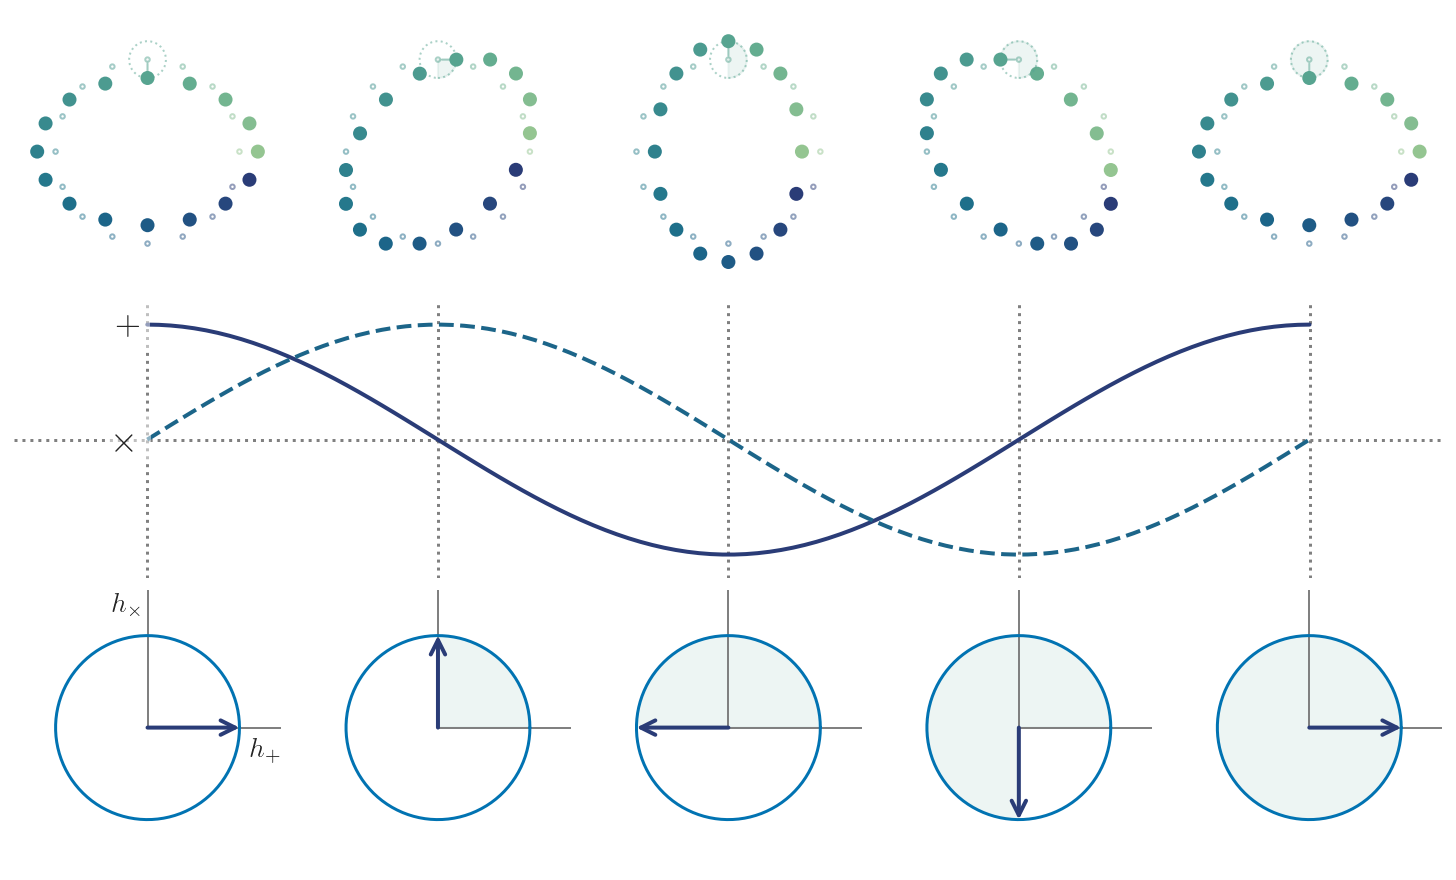

In [373]:
Nt = 5
wts = linspace(0, 2*pi, Nt)

ax_width = 2
nrow = 3
fig = figure(constrained_layout=True, figsize=(ax_width*Nt, nrow*ax_width))
gs = fig.add_gridspec(nrow, Nt)

# draw a the trajectory of a highlighted point
i0 = 4
x, y = X[i0], Y[i0]
dxs, dys = [], []
for wt in linspace(0, 2*pi, 50):
    dx, dy = dxdy_circ_r([x, y], wt)
    dxs.append(dx)
    dys.append(dy)
dxs = array(dxs)
dys = array(dys)

# initial angle for highlighted point
th0 = arctan2(dys[0], dxs[0])

c = sns.color_palette('crest', n_colors=Npoints)
for i, wt in enumerate(wts):
    ax = fig.add_subplot(gs[0, i])
    dX, dY = dxdy_circ_r([X, Y], wt)
    
    # highlighted point
    wedge = Wedge([X[i0], Y[i0]], linalg.norm([dX[i0], dY[i0]]),  rad2deg(th0), rad2deg(th0+wt),
                  color=c[i0], alpha=0.1)
    ax.add_patch(wedge)
    ax.annotate("", xy=(X[i0] + dX[i0], Y[i0] + dY[i0]), xytext=(X[i0], Y[i0]),
                arrowprops=dict(arrowstyle="-", color=c[i0], alpha=0.5))
    ax.plot(x+dxs, y+dys, c=c[i0], alpha=0.5, lw=1, ls=':')
    
    
    ax.scatter(X, Y, label=wt, edgecolors=c, facecolor='none', s=5, alpha=0.5)
    ax.scatter(X + dX, Y + dY, c=c)

    ax.axis('off')
    ax.axis('equal')
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)

# for i, wt in enumerate(wts):
#     ax = fig.add_subplot(gs[1, i])
# #     ax.scatter(X, Y, label=wt, edgecolors='gray', facecolor='none', s=5, alpha=0.5)
    
#     dX, dY = dxdy_lin_p([X, Y], wt)
#     ax.scatter(X + dX, Y + dY, marker='o', s=2+50*(linalg.norm([dX, dY], axis=0)[0]))
    
#     dX, dY = dxdy_lin_c([X, Y], wt)
#     ax.scatter(X + dX, Y + dY, marker='o', s=2+50*(linalg.norm([dX, dY], axis=0)[0]))

#     ax.axis('off')
#     ax.axis('equal')
#     ax.set_xlim(-1.5, 1.5)
#     ax.set_ylim(-1.5, 1.5)

# get offset of first subplot center in display coordinates
w = ax.transData.transform((-1.2, 0))[0]

ax = fig.add_subplot(gs[1,:])

# convert the offset to coordinates of the new axis in
w_new = 0.85*ax.transData.inverted().transform((w,0))[0]
                                  
wts2 = linspace(0, 2*pi, 100)
ax.axhline(0, c='gray', ls=':')#c='0.8', lw=3, ls='--')
for wt in wts:
    ax.axvline(wt, 0, 1, c='gray', ls=':')

kws = dict(horizontalalignment='center', verticalalignment='center', bbox=dict(fc="w", lw=0, alpha=0.5))
ax.annotate(r'$+$', xy=(-0.1, 1), **kws)
ax.annotate(r'$\times$', xy=(-0.1, 0), **kws)

ax.plot(wts2, cos(wts2), lw=2, c=c[-1])
ax.plot(wts2, sin(wts2), lw=2, c=c[-5], ls='--')

ax.set_xlim(-w_new, 2*pi+w_new)
ax.set_ylim(-1.2, 1.2)
ax.axis('off');


for i, wt in enumerate(wts):
    ax = fig.add_subplot(gs[2, i])
    
    ax.axhline(0, 0.5, c='gray', lw=1)
    ax.axvline(0, 0.5, c='gray', lw=1)
    kws = dict(fontsize=14, horizontalalignment='right', verticalalignment='top')
    if i==0:
        ax.annotate(r'$h_+$', xy=(1.45, -0.1), **kws)
        ax.annotate(r'$h_\times$', xy=(-0.05, 1.5), **kws)
    ax.plot(cos(wts2), sin(wts2))
    
    wedge = Wedge([0, 0], 1, 0, rad2deg(wt), color=c[i0], alpha=0.1)
    ax.add_patch(wedge)
    ax.annotate("", xy=(cos(wt), sin(wt)), xytext=(0, 0),
                arrowprops=dict(arrowstyle="->", color=c[-1], lw=2, shrinkA=0, shrinkB=0))
    
    ax.axis('off')
    ax.axis('equal')
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)

In [440]:
# let's monkey patch the Wedge class so that we can get elliptical wedges
from matplotlib.path import Path
from matplotlib.patches import Patch
from matplotlib import transforms
        
class EllipticalWedge(Patch):
    """Wedge shaped patch."""
    def __str__(self):
        pars = (self.center[0], self.center[1], self.r,
                self.theta1, self.theta2, self.width)
        fmt = "Wedge(center=(%g, %g), r=%g, theta1=%g, theta2=%g, width=%s)"
        return fmt % pars

    def __init__(self, center, r, theta1, theta2, ellip=1, angle=0, width=None, **kwargs):
        """
        A wedge centered at *x*, *y* center with radius *r* that
        sweeps *theta1* to *theta2* (in degrees).  If *width* is given,
        then a partial wedge is drawn from inner radius *r* - *width*
        to outer radius *r*.

        Valid keyword arguments are:

        %(Patch_kwdoc)s
        """
        super().__init__(**kwargs)
        self.center = center
        self.r, self.width = r, width
        self.theta1, self.theta2 = theta1, theta2
        self.ellip = ellip
        self.angle = angle
        self._patch_transform = transforms.IdentityTransform()
        self._recompute_path()


    def _recompute_path(self):
        # Inner and outer rings are connected unless the annulus is complete
        if abs((self.theta2 - self.theta1) - 360) <= 1e-12:
            theta1, theta2 = 0, 360
            connector = Path.MOVETO
        else:
            theta1, theta2 = self.theta1, self.theta2
            connector = Path.LINETO

        # Form the outer ring
        arc = Path.arc(theta1, theta2)

        if self.width is not None:
            # Partial annulus needs to draw the outer ring
            # followed by a reversed and scaled inner ring
            v1 = arc.vertices
            v2 = arc.vertices[::-1] * (self.r - self.width) / self.r
            v = np.concatenate([v1, v2, [v1[0, :], (0, 0)]])
            c = np.concatenate([
                arc.codes, arc.codes, [connector, Path.CLOSEPOLY]])
            c[len(arc.codes)] = connector
        else:
            # Wedge doesn't need an inner ring
            v = np.concatenate([
                arc.vertices, [(0, 0), arc.vertices[0, :], (0, 0)]])
            c = np.concatenate([
                arc.codes, [connector, connector, Path.CLOSEPOLY]])
        
        # squeeze and rotate
        v[:,1] *= self.ellip
        
        costh = cos(self.angle)
        sinth = sin(self.angle)
        R = array([[costh, -sinth], [sinth, costh]])
        v = dot(R, v.T).T
        
        # Shift and scale the wedge to the final location.
        v *= self.r
        v += np.asarray(self.center)
        
        self._path = Path(v, c)

    def set_center(self, center):
        self._path = None
        self.center = center
        self.stale = True


    def set_radius(self, radius):
        self._path = None
        self.r = radius
        self.stale = True

    def set_theta1(self, theta1):
        self._path = None
        self.theta1 = theta1
        self.stale = True


    def set_theta2(self, theta2):
        self._path = None
        self.theta2 = theta2
        self.stale = True


    def set_width(self, width):
        self._path = None
        self.width = width
        self.stale = True

    def get_path(self):
        if self._path is None:
            self._recompute_path()
        return self._path

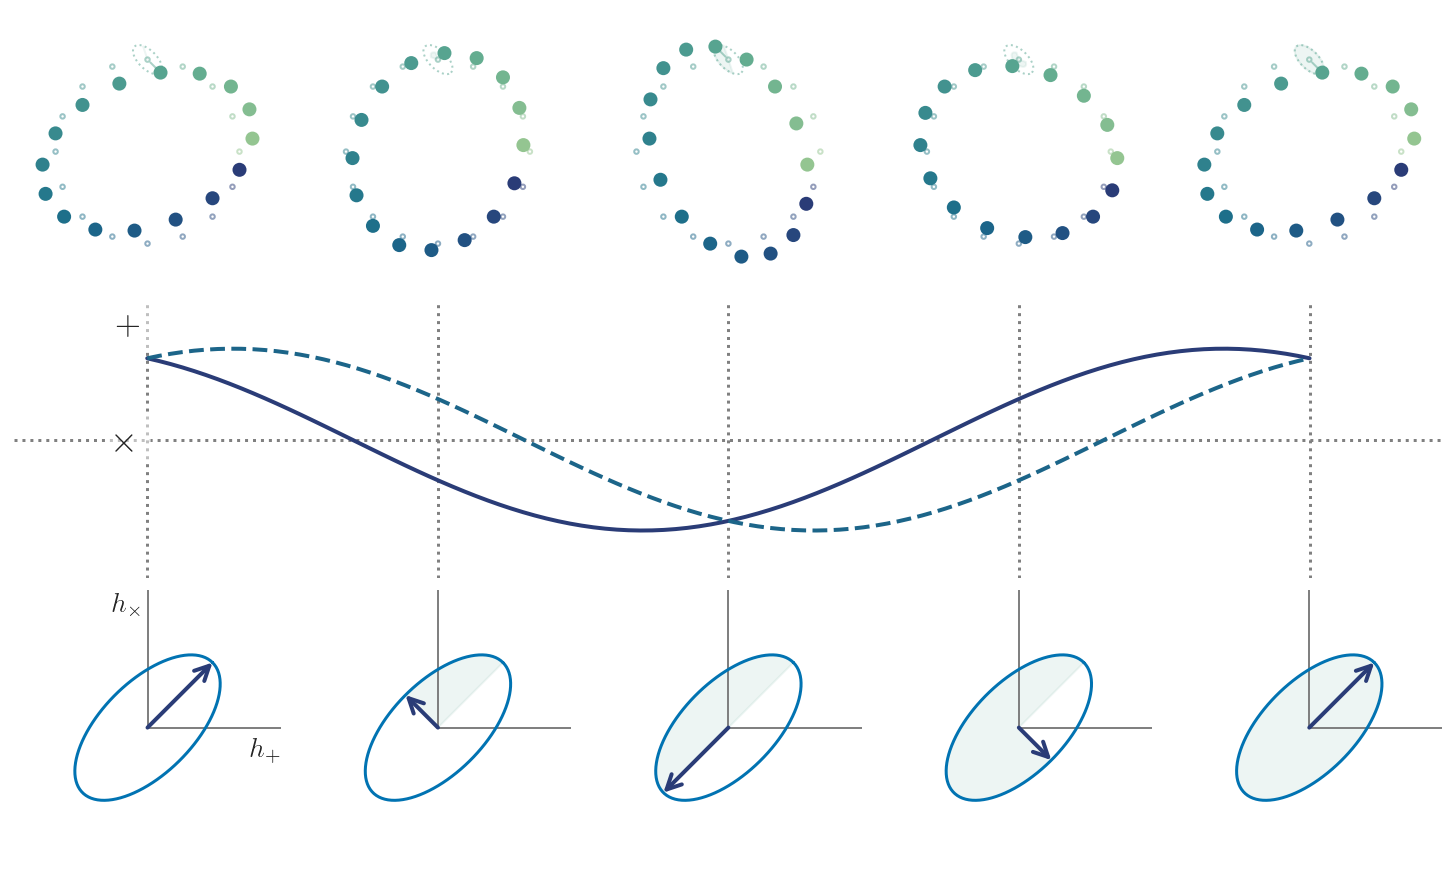

In [442]:
Nt = 5
wts = linspace(0, 2*pi, Nt)

ax_width = 2
nrow = 3
fig = figure(constrained_layout=True, figsize=(ax_width*Nt, nrow*ax_width))
gs = fig.add_gridspec(nrow, Nt)

ellip_kws = dict(ellip=0.5, theta=pi/4)
# draw a the trajectory of a highlighted point
i0 = 4
x, y = X[i0], Y[i0]
dxs, dys = [], []
for wt in linspace(0, 2*pi, 50):
    dx, dy = dxdy_ellip([x, y], wt, **ellip_kws)
    dxs.append(dx)
    dys.append(dy)
dxs = array(dxs)
dys = array(dys)

# initial angle for highlighted point
th0 = arctan2(dys[0], dxs[0])

c = sns.color_palette('crest', n_colors=Npoints)
for i, wt in enumerate(wts):
    ax = fig.add_subplot(gs[0, i])
    dX, dY = dxdy_ellip([X, Y], wt, **ellip_kws)
    
    # highlighted point
    wedge = EllipticalWedge([X[i0], Y[i0]], linalg.norm([dX[i0], dY[i0]]),  rad2deg(th0), rad2deg(th0+wt),
                            ellip=0.5, angle=3*pi/4, color=c[i0], alpha=0.1)
    ax.add_patch(wedge)
    ax.annotate("", xy=(X[i0] + dX[i0], Y[i0] + dY[i0]), xytext=(X[i0], Y[i0]),
                arrowprops=dict(arrowstyle="-", color=c[i0], alpha=0.5))
    ax.plot(x+dxs, y+dys, c=c[i0], alpha=0.5, lw=1, ls=':')
    
    
    ax.scatter(X, Y, label=wt, edgecolors=c, facecolor='none', s=5, alpha=0.5)
    ax.scatter(X + dX, Y + dY, c=c)

    ax.axis('off')
    ax.axis('equal')
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)

# for i, wt in enumerate(wts):
#     ax = fig.add_subplot(gs[1, i])
# #     ax.scatter(X, Y, label=wt, edgecolors='gray', facecolor='none', s=5, alpha=0.5)
    
#     dX, dY = dxdy_lin_p([X, Y], wt)
#     ax.scatter(X + dX, Y + dY, marker='o', s=2+50*(linalg.norm([dX, dY], axis=0)[0]))
    
#     dX, dY = dxdy_lin_c([X, Y], wt)
#     ax.scatter(X + dX, Y + dY, marker='o', s=2+50*(linalg.norm([dX, dY], axis=0)[0]))

#     ax.axis('off')
#     ax.axis('equal')
#     ax.set_xlim(-1.5, 1.5)
#     ax.set_ylim(-1.5, 1.5)

# get offset of first subplot center in display coordinates
w = ax.transData.transform((-1.2, 0))[0]

ax = fig.add_subplot(gs[1,:])

# convert the offset to coordinates of the new axis in
w_new = 0.85*ax.transData.inverted().transform((w,0))[0]
                                  
wts2 = linspace(0, 2*pi, 100)
ax.axhline(0, c='gray', ls=':')#c='0.8', lw=3, ls='--')
for wt in wts:
    ax.axvline(wt, 0, 1, c='gray', ls=':')

kws = dict(horizontalalignment='center', verticalalignment='center', bbox=dict(fc="w", lw=0, alpha=0.5))
ax.annotate(r'$+$', xy=(-0.1, 1), **kws)
ax.annotate(r'$\times$', xy=(-0.1, 0), **kws)

hp2, hc2 = hphc_ellip(wts2, A=1, **ellip_kws)

ax.plot(wts2, hp2, lw=2, c=c[-1])
ax.plot(wts2, hc2, lw=2, c=c[-5], ls='--')

ax.set_xlim(-w_new, 2*pi+w_new)
ax.set_ylim(-1.2, 1.2)
ax.axis('off');


hp, hc = hphc_ellip(wts, A=1, **ellip_kws)

for i, wt in enumerate(wts):
    ax = fig.add_subplot(gs[2, i])
    
    ax.axhline(0, 0.5, c='gray', lw=1)
    ax.axvline(0, 0.5, c='gray', lw=1)
    kws = dict(fontsize=14, horizontalalignment='right', verticalalignment='top')
    if i==0:
        ax.annotate(r'$h_+$', xy=(1.45, -0.1), **kws)
        ax.annotate(r'$h_\times$', xy=(-0.05, 1.5), **kws)
    ax.plot(hp2, hc2)
    
    wedge = EllipticalWedge([0, 0], 1, 0, rad2deg(wt), ellip=0.5, angle=pi/4, color=c[i0], alpha=0.1)
    ax.add_patch(wedge)
    ax.annotate("", xy=(hp[i], hc[i]), xytext=(0, 0),
                arrowprops=dict(arrowstyle="->", color=c[-1], lw=2, shrinkA=0, shrinkB=0))
    
    ax.axis('off')
    ax.axis('equal')
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)